# **Projet Python**
*Nicolas Dumont & Julien Vion*

L’objectif est de calculer les Volume Weighted Average Price horaires du Bitcoin, pour chacun des exchanges à 
disposition.

## 1 - Input

Vous aurez à disposition, sous forme de fichiers .csv, la liste des trades de bitcoin ayant eu lieu sur différents 
exchanges de Cryptomonnaies. Vous devrez importer les données issues des différents fichiers.

In [1]:
# Premièrement nous importons les librairies dont nous aurons besoin afin de manipuler les CSV et créer le dataframe final.
import pandas as pd
import numpy as np
import os

In [2]:
# Nous stockons chaque CSV dans un dictionnaire avec leur nom en clé.

all_exch = {}

for file in os.listdir('CSV'):
    if file.endswith(".csv"):
        all_exch.update({file.strip(".csv"):pd.read_csv('CSV/'+file)})

{'bfly':                    timestamp     price    amount
 0    2021-02-24 23:59:33.720  49712.15  0.005400
 1    2021-02-24 23:44:16.980  49603.44  0.077000
 2    2021-02-24 22:32:39.320  48864.19  0.120000
 3    2021-02-24 22:15:19.030  48252.47  0.120000
 4    2021-02-24 22:15:17.157  48247.38  0.120000
 ..                       ...       ...       ...
 229  2021-02-24 00:14:48.747  48263.33  0.250300
 230  2021-02-24 00:11:03.583  48574.05  0.000245
 231  2021-02-24 00:11:02.263  48574.05  0.001000
 232  2021-02-24 00:05:08.513  48683.05  0.010000
 233  2021-02-24 00:02:59.720  48929.54  0.120000
 
 [234 rows x 3 columns],
 'bfnx':                       timestamp         price    amount
 0       2021-02-24 23:59:58.181  49716.000000  0.010000
 1       2021-02-24 23:59:58.176  49713.000000  0.005000
 2       2021-02-24 23:59:51.526  49715.000000  0.005000
 3       2021-02-24 23:59:46.698  49726.000000  0.005000
 4       2021-02-24 23:59:46.353  49715.000000  0.005000
 ...           

## 2 - Manipulation de Données

Vous devrez ensuite modifier la structure des données pour répondre à vos besoins, probablement effectuer des 
jointures depuis les différents fichiers.

In [3]:
# Nous créons une nouvelle table contenant l'ensemble des échanges.
exchanges = pd.concat([list(all_exch.values())][0])

#Nous rajoutons cette table au dictionnaire contenant en clé le nom donné à chaque table et en valeur la table en question.
all_exch.update({"global": exchanges})

# Nous itérons sur le dictionnaire afin de convertir la colonne date de chaque table dans le bon format.
for key, value in all_exch.items():
    value["timestamp"] = pd.to_datetime(value["timestamp"])
    value.set_index("timestamp", inplace=True)

## 3 - CALCUL

Enfin, une fois les données préparées, vous pourrez passer à l’étape de calcul des VWAP pour chaque tranche d’une 
heure, pour chaque exchange, puis au global (tous les exchanges réunis). Une fois le calcul effectué, vous pourrez 
exporter vos résultats sous la forme d’un nouveau fichier .csv.

In [4]:
#Nous stockons un dataframe sous le bon format à l'intérieur de la variable result afin de pouvoir merge dessus plus tard

result = exchanges.resample("H").sum()

# Nous calculons une colonne VWAP pour chaque table.

for key, value in all_exch.items():
    value["Price*Amount " + key] = (value["price"] * value["amount"])
    value = value.resample("H").sum()
    value["VWAP " + key] = (value["Price*Amount " + key]) / value["amount"]
    result = result.join(value[["VWAP " + key]])
    

# Nous supprimons la colonnes obsoletes du dataframe

del result["price"]
del result["amount"]

In [5]:
# Nous verifions le nombre de valeurs nulles dans le tableau ainsi que les colonnes
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2021-02-24 00:00:00 to 2021-02-24 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   VWAP bfly    23 non-null     float64
 1   VWAP bfnx    24 non-null     float64
 2   VWAP bnu     24 non-null     float64
 3   VWAP btrx    24 non-null     float64
 4   VWAP bse     24 non-null     float64
 5   VWAP gmni    24 non-null     float64
 6   VWAP itbi    24 non-null     float64
 7   VWAP krkn    24 non-null     float64
 8   VWAP lmax    24 non-null     float64
 9   VWAP okcn    24 non-null     float64
 10  VWAP tmp     24 non-null     float64
 11  VWAP global  24 non-null     float64
dtypes: float64(12)
memory usage: 3.0 KB


In [6]:
# Nous remplaçons les valeurs nulles par la valeur précédente, qui servira d'estimation concernant ce que la valeur aurait pu être.
# Nous avons hésité à plutot les remplacer par 0 puisque n'avoir aucune valeur signifie qu'il n'y avait pas de transaction.
# Cependant dans une optique de création de graphique, 0 est une valeur extrême qui entraverait la compréhension en rajoutant des résultats abhérants.

# Nous supprimons aussi les décimaux en arondissant à l'entier le plus proche afin de rendre le tableau plus lisible.

result = result.fillna(method="ffill").round(decimals=0).astype(int)

In [7]:
# Nous vérifions le tableau en son ensemble.
# Il est jugé que le tableau a suffisament peu de lignes pour que l'utilisation de .head ou .tail soit obsolète.

result

,VWAP bfly,VWAP bfnx,VWAP bnu,VWAP btrx,VWAP bse,VWAP gmni,VWAP itbi,VWAP krkn,VWAP lmax,VWAP okcn,VWAP tmp,VWAP global
timestamp,,,,,,,,,,,,
2021-02-24 00:00:00,48007,47779,47847,47861,47945,47982,47772,47698,47881,47955,47944,47883
2021-02-24 01:00:00,49608,49442,49196,49343,49317,49458,49510,49179,49251,49423,49220,49313
2021-02-24 02:00:00,50197,50237,50200,50264,50249,50268,50260,50215,50228,50219,50284,50244
2021-02-24 03:00:00,50948,50608,50523,50529,50498,50494,50534,50537,50458,50435,50473,50514
2021-02-24 04:00:00,50893,50890,50901,50914,50943,50935,51020,50917,50852,51023,50988,50928
2021-02-24 05:00:00,50893,50344,50384,50537,50514,50529,50416,50421,50474,50399,50440,50456
2021-02-24 06:00:00,49979,49714,50046,50034,49982,49935,49908,49916,50062,49940,49940,49913
2021-02-24 07:00:00,49680,49899,49862,50033,49960,50035,49945,49994,49996,50030,49974,49963
2021-02-24 08:00:00,50144,50630,50560,50587,50541,50477,50600,50545,50553,50483,50594,50579


In [8]:
# Export en tant que CSV
# nb: Nous n'exportons pas dans le fichier CSV car autrement en relançant le noyau les boucles import de CSV importent aussi result.

result.to_csv("result.csv", index=False)

## 4 - Graphiques

Afin d'aller plus loin, nous allons utiliser les données trouvées afin de modéliser quelques graphiques nous permettant de mieux comprendre les tendances et fluctuations horaires des échanges en bitcoin.

In [9]:
# Nous utilisons la méthode describe afin de récupérer des données nous permettant d'effectuer certains tests statistiques
# Nous transposons la table afin de pouvoir utiliser les quartiles en nom de colonne.
stat = result.describe().astype(int).transpose()
stat

,count,mean,std,min,25%,50%,75%,max
VWAP bfly,24,49776,890,48007,49247,49681,50489,51229
VWAP bfnx,24,49754,845,47779,49228,49761,50483,50977
VWAP bnu,24,49774,815,47847,49256,49802,50485,50901
VWAP btrx,24,49821,834,47861,49304,49823,50541,50948
VWAP bse,24,49798,816,47945,49284,49812,50502,50943
VWAP gmni,24,49805,796,47982,49274,49820,50481,50935
VWAP itbi,24,49804,851,47772,49373,49804,50509,51020
VWAP krkn,24,49780,850,47698,49221,49827,50527,50988
VWAP lmax,24,49804,806,47881,49306,49836,50482,50934
VWAP okcn,24,49822,819,47955,49345,49882,50447,51023


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

,timestamp,variable,value
0,2021-02-24 00:00:00,VWAP bfly,48007
1,2021-02-24 01:00:00,VWAP bfly,49608
2,2021-02-24 02:00:00,VWAP bfly,50197
3,2021-02-24 03:00:00,VWAP bfly,50948
4,2021-02-24 04:00:00,VWAP bfly,50893
...,...,...,...
283,2021-02-24 19:00:00,VWAP global,49269
284,2021-02-24 20:00:00,VWAP global,48929
285,2021-02-24 21:00:00,VWAP global,48487
286,2021-02-24 22:00:00,VWAP global,48575


<ipython-input-39-c5f654a88c67>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(result.index.hour*3)


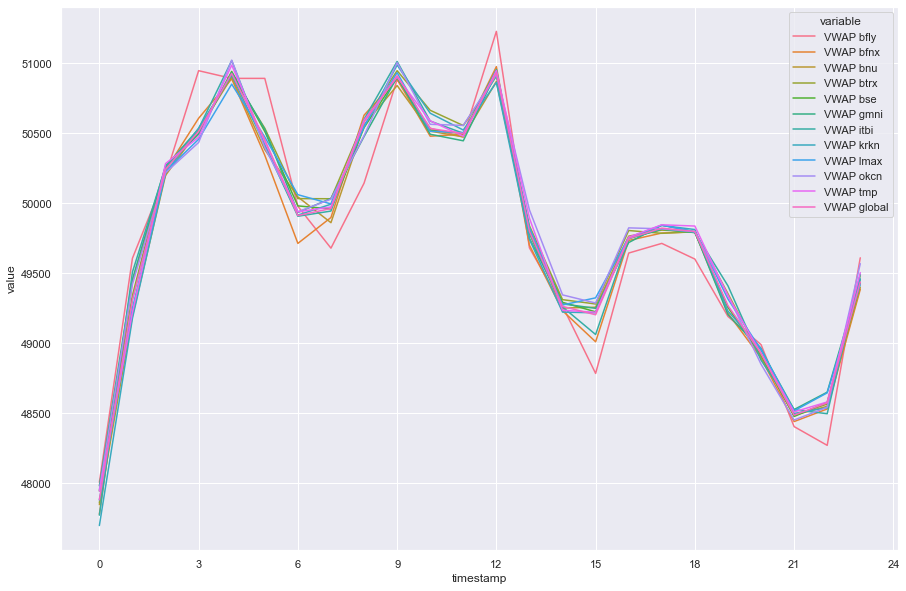

In [39]:
# Nous utilisons un fond plus sombre avec grille afin d'avoir des graphiques plus lisibles.

sns.set_theme(style="darkgrid")

# Ici nous traçons un graphique nous permettant d'observer qu'aucun exchange ne contient de valeur trop différente des autres.
# Il nous permet aussi d'observer que les montants les plus grands se situent vers 4 heures et 12 heures.

g = sns.lineplot(x="timestamp", y="value",
        data=pd.melt(result.reset_index(), ["timestamp"]), hue = "variable")
g.set_xticklabels(result.index.hour*3)
sns.set(rc={"figure.figsize":(15, 10)}) #width=3, #height=4

# Là où le graphique nous permet de bien identifier les tendances horaires, différencier les échanges reste compliquer.

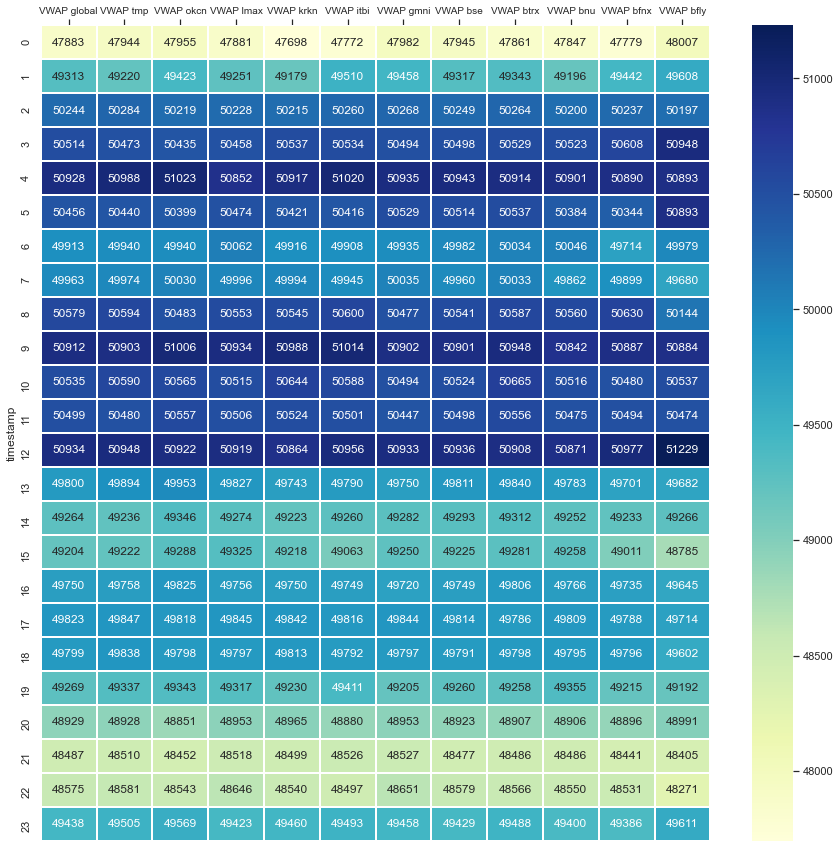

In [38]:
# Nous dessinons une heatmap nous permettant de mieux différencier les échanges les plus lucratifs.
f, ax = plt.subplots(figsize=(15, 15))
figsize = f.get_size_inches()
f.set_size_inches(figsize * 1)  # scale current size by 1.5
sns.heatmap(result, annot=True, cmap="YlGnBu", fmt="d", linewidths=1, ax=ax, yticklabels=result.index.hour)
ax.invert_xaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(labelsize=10)

In [47]:
#Oresult[result > result.quantile(0.9)]

,VWAP bfly,VWAP bfnx,VWAP bnu,VWAP btrx,VWAP bse,VWAP gmni,VWAP itbi,VWAP krkn,VWAP lmax,VWAP okcn,VWAP tmp,VWAP global
timestamp,,,,,,,,,,,,
2021-02-24 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-24 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-24 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-24 03:00:00,50948,0,0,0,0,0,0,0,0,0,0,0
2021-02-24 04:00:00,0,50890,50901,50914,50943,50935,51020,50917,50852,51023,50988,50928
2021-02-24 05:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-24 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-24 07:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-24 08:00:00,0,0,0,0,0,0,0,0,0,0,0,0


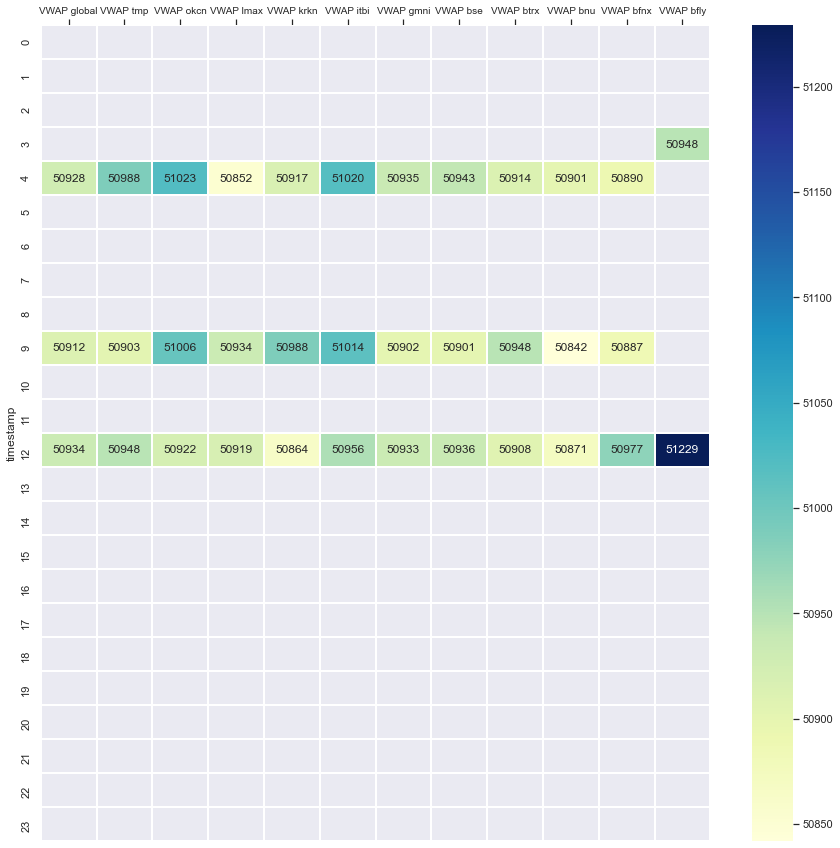

In [65]:
# On répète la même heatmap mais cette fois seulement avec les plus grosses valeurs afin de pouvoir mieux les differencier.

f, ax = plt.subplots(figsize=(15, 15))
figsize = f.get_size_inches()
f.set_size_inches(figsize * 1)  # scale current size by 1.5
sns.heatmap(result[result > result.quantile(0.9)], annot=True, fmt=".0f",cmap="YlGnBu", linewidths=1, ax=ax, yticklabels=result.index.hour[0:24])
ax.invert_xaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(labelsize=10)

VWAP bfly:


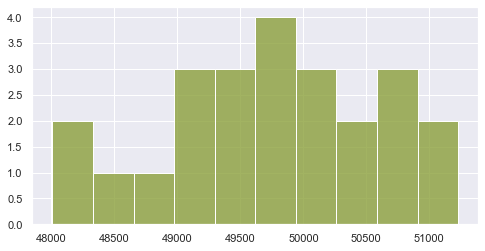

VWAP bfnx:


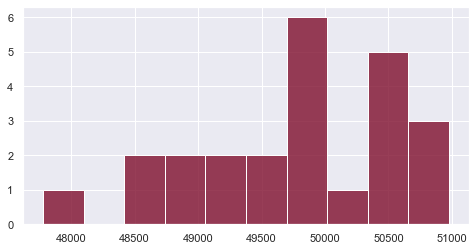

VWAP bnu:


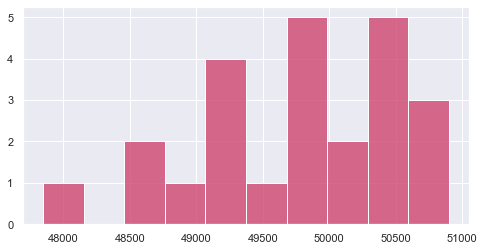

VWAP btrx:


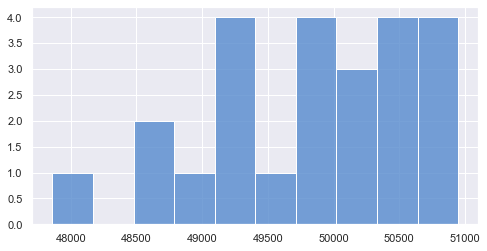

VWAP bse:


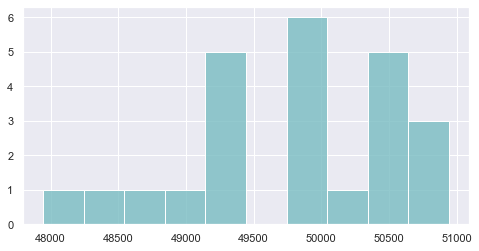

VWAP gmni:


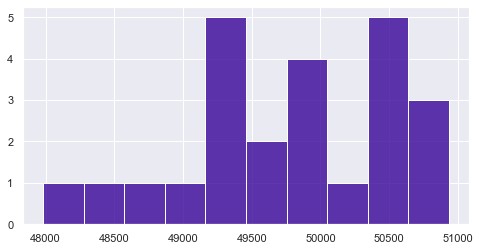

VWAP itbi:


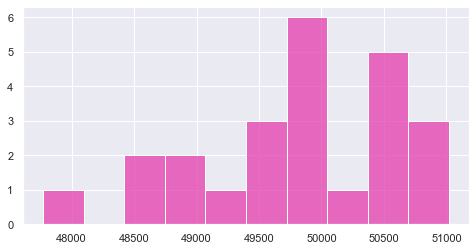

VWAP krkn:


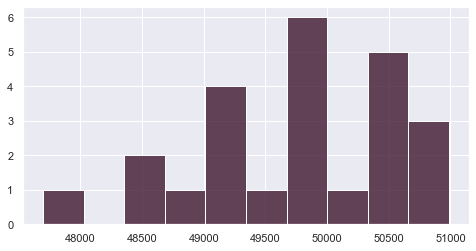

VWAP lmax:


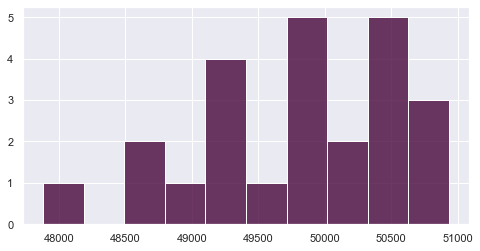

VWAP okcn:


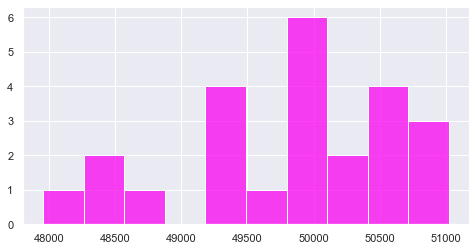

VWAP tmp:


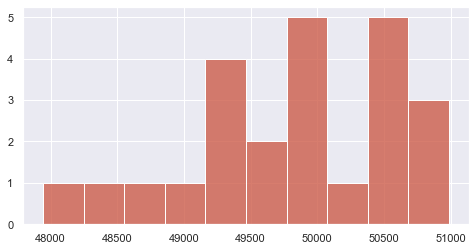

VWAP global:


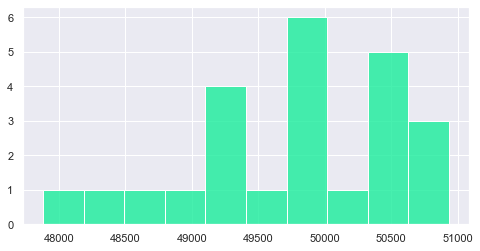

In [90]:
# Nous traçons des histogrammes regroupant les échanges en classes statistiques.

for col in result:
    print(col + ":")
    plt.hist(result[col], color=(random.random(),random.random(),random.random(), 0.8))
    plt.show()

In [63]:
# Nous calculons les coefficients Pearson et Yule-Kendall afin de déterminer s'il existe des valeurs extrêmes.
# Nous remarquerons aussi les tendances des données

stat["Yule-Kendall"] = ((stat["75%"]-stat["50%"])-(stat["50%"]-stat["25%"]))/(stat["75%"]-stat["25%"])

# Afin de calculer la mode d'une classe statistique nous divisons par deux la somme des limites de la classe ayant le plus d'effectif.
# Ici nous choisissons [49500, 50000] grâce à nos histogrammes qui nous montrent que la plupart des valeurs se situent là.

mode = (50000+49500)/2

stat["Pearson"] = (stat["mean"]-mode)/stat["std"]

stat

# Les coefficients Yule-Kendall et Pearson sont positifs, les données sont donc légèrements dissymétriques à gauche.
# Dans le cas de l'échange stmp, Yule-Kendall est négatif et Pearson est positif, nous avons donc peut-être affaire a des valeurs extrêmes.

,count,mean,std,min,25%,50%,75%,max,Yule-Kendall,Pearson
VWAP bfly,24,49776,890,48007,49247,49681,50489,51229,0.301127,0.029213
VWAP bfnx,24,49754,845,47779,49228,49761,50483,50977,0.150598,0.004734
VWAP bnus,24,49774,815,47847,49256,49802,50485,50901,0.111473,0.029448
VWAP btrx,24,49821,834,47861,49304,49823,50541,50948,0.160873,0.085132
VWAP cbse,24,49798,816,47945,49284,49812,50502,50943,0.133005,0.058824
VWAP gmni,24,49805,796,47982,49274,49820,50481,50935,0.095278,0.069095
VWAP itbi,24,49804,851,47772,49373,49804,50509,51020,0.241197,0.063455
VWAP krkn,24,49780,850,47698,49221,49827,50527,50988,0.071975,0.035294
VWAP lmax,24,49804,806,47881,49306,49836,50482,50934,0.098639,0.066998
VWAP okcn,24,49822,819,47955,49345,49882,50447,51023,0.025408,0.087912


### Conclusion

Les échanges dénotant les prix les plus élevés ont eu lieu a 4 heure, 9 heure et 12 heure. Il est important de noter que l'horaire est la variable insoufflant le plus de variance au prix. En effet, là où l'échange le plus lucratif est le bfly, le gain relatif procuré reste faible.

Dans un soucis d'optimisation, nous conseillerons de favoriser les échanges de bitcoin sur ces horaires et sur avec cet échange.

Lors de chaque échange, les données penchent légèrement vers la droite. Cela signifie que les VWAP seront plus souvent aux alentours de 50 000 que de 49 000.

De plus il n'existe qu'un seul échange avec des valeurs possiblement extrêmes. Cela confirme ce que nous avons expliqué plus haut : les échanges en bitcoin restent donc toujours aux alentours d'un même prix.

Par ce constat, nous pouvons conclure que le marché du bitcoin est déjà bien établit avec des fluctuations d'offre et de demande faibles.